In [14]:
import pysam
import collections
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**User Edit the following cell:**

In [15]:
# user input the folder containing the bamfiles
folder = './spikein_from_bob/'
# also enter the input and cmc files
# make sure to order them in correct paired order
input_files = ['HG_input_filtered.bam','HG_FA_input_filtered.bam','LG_input_filtered.bam','LG_FA_input_filtered.bam']
cmc_files = ['HG_CMC_filtered.bam','HG_FA_CMC_filtered.bam','LG_CMC_filtered.bam','LG_FA_CMC_filtered.bam']
# user input names for each experiment in same order as files
exp_names = ['HG', 'HG_FA', 'LG', 'LG_FA']

# user input window size for calculating peak values by Carlile method
window_size = 20 

# user input file containing known sites
# set as '' if don't want to include known sites
known_sites_file = 'Carlile_known_human_SuppT7.csv'

In [16]:
# get the full filename including path
bamfiles = [os.path.join(folder, bamfile) for bamfile in input_files + cmc_files]

# get just the sample name from the filename
input_samples = [file.split('.')[0] for file in input_files]
cmc_samples = [file.split('.')[0] for file in cmc_files]
samples = input_samples + cmc_samples

exp_long_names = [f'{i}_Peak_ws{window_size}' for i in exp_names]

In [17]:
def get_end_count(bamfile):
    '''
    Given a bamfile
    Gets 5' R1 end counts
    Returns 2 dicts of the form [ref_name][pos]
    one will have the counts at each pos, the other
    has the ref_base at each pos
    Also returns a list of all ref_names found
    '''
    samfile = pysam.AlignmentFile(bamfile, 'rb')
    reads = samfile.fetch()
    
    counts = {}
    bases = {}
    
    for read in reads:
        if read.is_read1 and not read.is_reverse:
            ref = read.reference_name
            pos = read.reference_start + 1 # Read 1, 5-prime (add 1 since pysam 0-based)
            base = read.get_reference_sequence()[0].upper()
            if ref not in counts:
                counts[ref] = collections.defaultdict(int)
                bases[ref] = {}

            counts[ref][pos] += 1
            if pos in bases[ref] and bases[ref][pos] != base:
                raise SystemError(f'Different bases found at position {pos}: current={base} previous={bases[ref][pos]}')
            bases[ref][pos] = base
    
    return counts, bases, samfile.references

In [18]:
# get 5' R1 end counts, along with corresponding bases for each sample
counts = {}
bases = {}
for sample, bamfile in zip(samples, bamfiles):
    counts[sample], bases[sample], ref_names = get_end_count(bamfile)
    
print('Note - expecting to find 5.8S, 18S, 28S in reference gene names')
print('if they are not there the following function will need to be modified')
for ref_name in ref_names:
    print(ref_name)

Note - expecting to find 5.8S, 18S, 28S in reference gene names
if they are not there the following function will need to be modified
NR_145820.1_HomosapiensRNA,18SribosomalN1(RNA18SN1),ribosomalRNA
NR_145822.1_HomosapiensRNA,28SribosomalN1(RNA28SN1),ribosomalRNA
NR_146153.1_HomosapiensRNA,5.8SribosomalN3(RNA5-8SN3),ribosomalRNA


In [19]:
def get_abbreviated_ref_name(ref_name):
    '''
    Convert longer ref name to just 5-8S, 18S, or 28S
    so that output names are easier to read
    '''
    for abbreviation in ('5.8S', '18S', '28S'):
        if abbreviation in ref_name:
            abbreviation = abbreviation.replace('.','-')
            return abbreviation
    return ref_name # unable to find the abbreviation

In [20]:
# convert to a pandas dataframe (one for each ref_name)
ref_df = {}
for ref_name in ref_names:
    # get the counts from each sample for that ref_name
    # also find the maximum pos across all samples
    d = {}
    combined_bases = {}
    max_pos = -1
    for sample in samples:
        d[sample] = counts[sample][ref_name]
        combined_bases.update(bases[sample][ref_name])
        max_pos = max(max_pos, max(d[sample]))

    # find any positions that got zero reads in all samples
    # assign one sample to have a 0 there, and the rest of
    # the sample will get filled in with NaN and then 0 later
    for i in range(1,max_pos+1):
        if i not in combined_bases:
            d[sample][i] = 0 # just assign it to one of the samples
            combined_bases[i] = '-'

    df = pd.DataFrame.from_dict(d)
    df = df.fillna(0) # replace NaN with 0 for positions that had no counts
    df['Sequence'] = pd.Series(combined_bases)
    
    # put columns in order of input samples, cmc samples, sequence
    df = df[samples + ['Sequence']]
    
    # put in dict where key = ref_name
    ref_df[ref_name] = df

In [21]:
def scale_input(ref_df, input_name, cmc_name, exp_name):
    '''
    Given: dictionary {ref_name: df}, and a pair of input/cmc names
    Scale input to be same total reads as cmc for each input/cmc pair
    df is modified in-place in function (don't need to return it)
    '''
    # get total reads for input and CMC over all refs
    cmc_total = input_total = 0
    for df in ref_df.values():
        cmc_total += df[cmc_name].sum()
        input_total += df[input_name].sum()
    #print(f'{cmc_name} total reads:\t{cmc_total}')
    #print(f'{input_name} total reads:\t{input_total}')

    # get ratio of CMC / input
    ratio = cmc_total / input_total
    #print(ratio)

    # multiply the input reads times that ratio
    for df in ref_df.values():  # for each reference gene
        scaled_input = df[input_name].copy()
        scaled_input *= ratio
        df[input_name + '_scaled'] = pd.Series(scaled_input)

    print(f'{exp_name}\t{input_total:<8}\t{cmc_total:<8}\t{ratio:.4f}')

In [22]:
# scale the input counts for each input/cmc pair
print(f'Exp.\tInput_total\tCMC_total\tCMC/Input_ratio')
for exp_name, input_name, cmc_name in zip(exp_names, input_samples, cmc_samples):
    scale_input(ref_df, input_name, cmc_name, exp_name)  

Exp.	Input_total	CMC_total	CMC/Input_ratio
HG	85122.0 	115237.0	1.3538
HG_FA	87953.0 	93048.0 	1.0579
LG	89387.0 	112052.0	1.2536
LG_FA	141978.0	109477.0	0.7711


In [23]:
def get_peak_value(cmc_vals, inp_vals, pos, ws, verbose=False):
    '''
    Given: series of end counts for cmc/input pair and 
    a position and window-size
    Calculates peak value by looking at the end counts at 
    the 3' base (+1 from given position)
    Returns: peak value
    '''
    pos += 1 # look at 3' base where termination should pile up
    
    if pos > len(cmc_vals): # can't do last base since nothing is 3'
        return np.nan

    r_cmc = cmc_vals.loc[pos]
    r_inp = inp_vals.loc[pos]
    
    # for example if want to look at position 5 with ws=4
    # windows will include positions (3,4,5,6,7)
    lo_pos = max(1, pos - int(ws/2))
    hi_pos = pos + int(ws/2)
    
    wr_cmc = cmc_vals.loc[lo_pos:hi_pos].sum() - r_cmc
    wr_inp = inp_vals.loc[lo_pos:hi_pos].sum() - r_inp

    if (wr_cmc + wr_inp) == 0:
        return np.nan
    peak = ws * (r_cmc - r_inp) / (wr_cmc + wr_inp)
    
    if verbose:
        print(f'3-prime position to look at: {pos}')
        print(f'cmc reads at pos {pos}: {r_cmc}')
        print(f'input reads at pos {pos}: {r_inp}')
        print(f'pos: {pos}, lo_pos: {lo_pos}, hi_pos: {hi_pos}')
        print(cmc_vals.loc[lo_pos:hi_pos])
        print(inp_vals.loc[lo_pos:hi_pos])
        print(f'peak: {peak}')
    return peak

In [39]:
# make sure output files of the same name don't already exist
for ref_name, df in ref_df.items(): 
    output_name = get_abbreviated_ref_name(ref_name) + '.csv'
    if os.path.exists(output_name):
        raise SystemError(f'file {output_name} already exists')
    
# calculate peak values for each input/cmc pair
for exp_name, input_name, cmc_name in zip(exp_names, input_samples, cmc_samples):
    print(exp_name)
    peak_col = f'{exp_name}_Peak_ws{window_size}'
    for ref_name, df in ref_df.items(): # for each reference gene
        print('> ' + ref_name)
        peaks = []
        for pos in df.index: # for each position
            peaks.append(get_peak_value(df[cmc_name], df[input_name + '_scaled'], pos, window_size))
        df[peak_col] = peaks
        
# save df as csv for each reference gene
for ref_name, df in ref_df.items(): 
    # next line is to make sure cols are in right order
    df = df[samples + ['Sequence'] + [i+'_scaled' for i in input_samples] + exp_long_names]
    output_name = get_abbreviated_ref_name(ref_name) + '.csv'
    df.to_csv(output_name)
    print(f'{output_name} file was saved')

HG
> NR_145820.1_HomosapiensRNA,18SribosomalN1(RNA18SN1),ribosomalRNA
> NR_145822.1_HomosapiensRNA,28SribosomalN1(RNA28SN1),ribosomalRNA
> NR_146153.1_HomosapiensRNA,5.8SribosomalN3(RNA5-8SN3),ribosomalRNA
HG_FA
> NR_145820.1_HomosapiensRNA,18SribosomalN1(RNA18SN1),ribosomalRNA
> NR_145822.1_HomosapiensRNA,28SribosomalN1(RNA28SN1),ribosomalRNA
> NR_146153.1_HomosapiensRNA,5.8SribosomalN3(RNA5-8SN3),ribosomalRNA
LG
> NR_145820.1_HomosapiensRNA,18SribosomalN1(RNA18SN1),ribosomalRNA
> NR_145822.1_HomosapiensRNA,28SribosomalN1(RNA28SN1),ribosomalRNA
> NR_146153.1_HomosapiensRNA,5.8SribosomalN3(RNA5-8SN3),ribosomalRNA
LG_FA
> NR_145820.1_HomosapiensRNA,18SribosomalN1(RNA18SN1),ribosomalRNA
> NR_145822.1_HomosapiensRNA,28SribosomalN1(RNA28SN1),ribosomalRNA
> NR_146153.1_HomosapiensRNA,5.8SribosomalN3(RNA5-8SN3),ribosomalRNA
18S.csv file was saved
28S.csv file was saved
5-8S.csv file was saved


In [152]:
def make_scatter(df, exp_long_names, ref_name, known_sites):
    '''
    Given:
    df: dataframe for a particular ref gene
    exp_long_names: column names for the cols with the peak values
    ref_name: reference gene
    known_sites: list of known positions
    '''  
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    fig, ax = plt.subplots()
    for zorder, (d, color, style, label) in enumerate(cats):
        for exp_long_name in exp_long_names:
            x_vals = d.index
            y_vals = d[exp_long_name]
            ax.plot(x_vals, y_vals, style, color=color, label = label, zorder = zorder)
            label = ''
    ax.set_title(ref_name)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")        

In [153]:
# read in known Psi sites from Bob's updating of Carlile supplementary table 7
# Bob's positions are in the 'NCBI tx pos' column
# store them in abbrev_ref_to_known {abbrev_ref: [list of known sites]}
abbrev_ref_to_known = {}
if known_sites_file:
    known_df = pd.read_csv('Carlile_known_human_SuppT7_updated.csv')
    rna28s = known_df[known_df['gene name']=='RNA28S5']
    rna18s = known_df[known_df['gene name']=='RNA18S5']
    rna58s = known_df[known_df['gene name']=='RNA5-8S5']

    # make a dict to connect abbreviated reference names to known sites 
    for abbrev_ref, known_sites in zip(('5-8S', '18S', '28S'), (rna58s, rna18s, rna28s)):
        abbrev_ref_to_known[abbrev_ref] = list(known_sites['NCBI tx pos'])

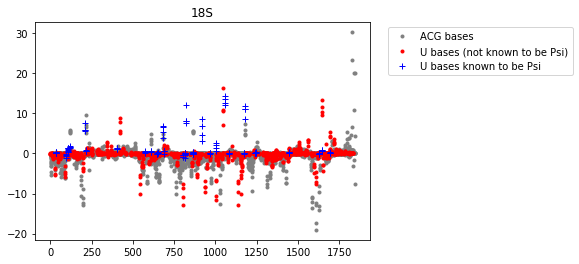

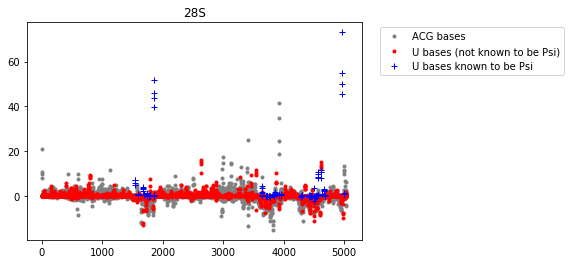

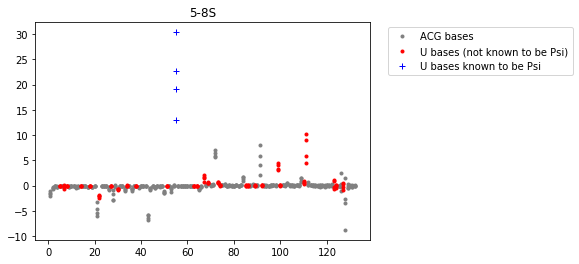

In [154]:
for ref_name, df, in ref_df.items():
    abbrev_ref = get_abbreviated_ref_name(ref_name)
    known_sites = abbrev_ref_to_known.get(abbrev_ref, []) # if no known sites given, use empty list
    make_scatter(df, exp_long_names, abbrev_ref, known_sites)